# Kaggle Titanic survival - logistic regression model

Can we predict which passengers would survive the sinking of the Titanic?

See:

https://www.kaggle.com/c/titanic/overview/evaluation

https://michaelallen1966.github.io/titanic/front_page.html

The original data comes from:

https://www.kaggle.com/c/titanic/data

Though we will download and use a data set that has been pre-processed ready for machine learning.  IMPORTANT - real data that you will work with will need preprocessing first.  There's a handy guide to preprocessing data here (based on the Titanic data we're using) : https://michaelallen1966.github.io/titanic/01_preprocessing.html

The data includes:

Variable  | Definition
----------|-----------
survival  | Survival (0 = No, 1 = Yes)
pclass    | Ticket class
sex       | Sex
Age       | Age in years
sibsp     | # of siblings / spouses aboard the Titanic
parch     | # of parents / children aboard the Titanic
ticket    | Ticket number
fare      | Passenger fare
cabin     | Cabin number
embarked  | Port of Embarkation(C=Cherbourg, Q=Queenstown, S=Southampton)

## Logistic regression

In this example we will use logistic regression (see https://en.wikipedia.org/wiki/Logistic_regression).

For an introductory video on logistic regression see: https://www.youtube.com/watch?v=yIYKR4sgzI8

Logistic regression takes a range of features (which we will normalise/standardise to put on the same scale) and returns a probability that a certain classification (survival in this case) is true.

We will go through the following steps:

* Download and save pre-processed data
* Split data into features (X) and label (y)
* Split data into training and test sets (we will test on data that has not been used to fit the model)
* Standardise data
* Fit a logistic regression model (from sklearn)
* Predict survival of the test set, and assess accuracy
* Review model coefficients (weights) to see importance of features
* Show probability of survival for passengers

## Load modules

A standard Anaconda install of Python (https://www.anaconda.com/distribution/) contains all the necessary modules.  Use your base environment if in doubt, or the ml_sammi environment if you have it installed.

In [1]:
import numpy as np
import pandas as pd
# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import statistics

## Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [2]:
download_required = True

if download_required:

    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'

    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

## Examine loaded data

The data is in the form of a Pandas DataFrame, so we have column headers providing information of what is contained in each column.

We will use the DataFrame `.head()` method to show the first few rows of the imported DataFrame. By default this shows the first 5 rows. Here we will look at the first 10.

In [4]:
data.head(10)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed,CabinLetterImputed,...,Embarked_missing,CabinLetter_A,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,CabinLetter_missing
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,6.0,0.0,3.0,28.0,0.0,0.0,8.4583,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,7.0,0.0,1.0,54.0,0.0,0.0,51.8625,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,8.0,0.0,3.0,2.0,3.0,1.0,21.0750,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,9.0,1.0,3.0,27.0,0.0,2.0,11.1333,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,10.0,1.0,2.0,14.0,1.0,0.0,30.0708,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Note that in the above, "Imputed" column names indicate whether that feature was blank in the original data and was filled in ("imputed") in the preprocessing (so "AgeImputed" value of 1.0 means the age was missing, 0.0 means it wasn't).  You can't have missing cells in Machine Learning, so you have to decide what to do when you have missing data.  This is part of the pre-processing step you'll need to do with real data, and there's more information about this in the pre-processing notebook here : https://michaelallen1966.github.io/titanic/01_preprocessing.html

We can also show a summary of the data with the `.describe()` method.

In [5]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed,CabinLetterImputed,...,Embarked_missing,CabinLetter_A,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,CabinLetter_missing
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208,0.198653,0.002245,0.771044,...,0.002245,0.016835,0.052750,0.066218,0.037037,0.035915,0.014590,0.004489,0.001122,0.771044
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429,0.399210,0.047351,0.420397,...,0.047351,0.128725,0.223659,0.248802,0.188959,0.186182,0.119973,0.066890,0.033501,0.420397
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The first column is a passenger index number. We will remove this, as this is not part of the original Titanic passenger data, and will not help us train our model.

In [6]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data
# inplace=True means change the dataframe itself - don't create a copy with this column dropped

data.drop('PassengerId', inplace=True, axis=1)

## Looking at a summary of passengers who survived or did not survive

Before running machine learning models, it is always good to have a look at your data. Here we will separate passengers who survived from those who died, and we will have a look at differences in features.

We will use a *mask* to select and filter passengers.  The mask applies Boolean values (True and False) to entries depending on a given condition.  Below, we use this to create a mask that has True values for any rows where the Survived value is 1.0 (ie where the patient survived), and then store only those rows in a separate dataframe called "survived".  Then we do the same thing but for those who died.

In [7]:
mask = data['Survived'] == 1 # Mask for passengers who survive
survived = data[mask] # filter using mask

mask = data['Survived'] == 0 # Mask for passengers who died
died = data[mask] # filter using mask

Now let's look at average (mean) values for each feature for those who `survived` and those who `died`.  We can make comparing them easier by putting these values in a new DataFrame so we can look at them side by side.  What do you notice?  What features do you think might have influenced survival?

In [8]:
summary = pd.DataFrame() # New empty DataFrame
summary['survived'] = survived.mean()
summary['died'] = died.mean()

In [9]:
summary

,survived,died
Survived,1.000000,0.000000
Pclass,1.950292,2.531876
Age,28.291433,30.028233
SibSp,0.473684,0.553734
Parch,0.464912,0.329690
Fare,48.395408,22.117887
AgeImputed,0.152047,0.227687
EmbarkedImputed,0.005848,0.000000
CabinLetterImputed,0.602339,0.876138
CabinNumber,18.961988,6.074681


## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict - survival here).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survived or not) `y`.

In [10]:
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

## Divide into training and tets sets

When we test a machine learning model we should always test it on data that has not been used to train the model.
We will use sklearn's `train_test_split` method to randomly split the data: 75% for training, and 25% for testing.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

Let's have a look at the standard deviation and the mean of the feature values in the training data (Standard Deviation for each feature shown first, then mean for each feature)

In [12]:
X_train.std(), X_train.mean()

(Pclass                  0.823707
 Age                    13.021815
 SibSp                   1.185279
 Parch                   0.795588
 Fare                   51.604012
 AgeImputed              0.398491
 EmbarkedImputed         0.054677
 CabinLetterImputed      0.416606
 CabinNumber            25.685466
 CabinNumberImputed      0.410484
 male                    0.475006
 Embarked_C              0.380380
 Embarked_Q              0.281791
 Embarked_S              0.441648
 Embarked_missing        0.054677
 CabinLetter_A           0.121524
 CabinLetter_B           0.219955
 CabinLetter_C           0.253410
 CabinLetter_D           0.166360
 CabinLetter_E           0.186250
 CabinLetter_F           0.132920
 CabinLetter_G           0.066915
 CabinLetter_T           0.038691
 CabinLetter_missing     0.416606
 dtype: float64,
 Pclass                  2.333832
 Age                    29.140479
 SibSp                   0.553892
 Parch                   0.372754
 Fare                   32.1793

## Standardise data

We can see above that there are quite different scales across different features in this data.  For example, passenger class is on a very different scale numerically than the fare paid.

We want all of our features to be on roughly the same scale. This generally leads to a better model, and also allows us to more easily compare the importance of different features.

We will use standardisation to scale our feature values, where we use the mean and standard deviation of the training set of data to normalise the data. We subtract the mean of the training set values, and divide by the standard deviation of the training data. Note that the mean and standard deviation of the training data are used to standardise the test set data as well.

Here we will use sklearn's `StandardScaler method`. This method also copes with problems we might otherwise have (such as if one feature has zero standard deviation in the training set).  We write a little function so whenever we need to standardise some data, we can just call this function, pass in the training and test feature (X) data, and it'll return the same data but standardised.

In [13]:
def standardise_data(X_train, X_test):

    # Initialise a new scaling object for normalising input data
    sc = StandardScaler()

    # Apply the scaler to the training and test sets
    train_std=sc.fit_transform(X_train)
    test_std=sc.fit_transform(X_test)

    return train_std, test_std

Now let's call this function and use it to standardise our training and test data.

In [14]:
X_train_std, X_test_std = standardise_data(X_train, X_test)

## Visualise Features

In [15]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed,CabinLetterImputed,CabinNumber,CabinNumberImputed,...,Embarked_missing,CabinLetter_A,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,CabinLetter_missing
298,1.0,28.00,0.0,0.0,30.5000,1.0,0.0,0.0,106.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
884,3.0,25.00,0.0,0.0,7.0500,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
247,2.0,24.00,0.0,2.0,14.5000,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
478,3.0,22.00,0.0,0.0,7.5208,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
305,1.0,0.92,1.0,2.0,151.5500,0.0,0.0,0.0,22.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


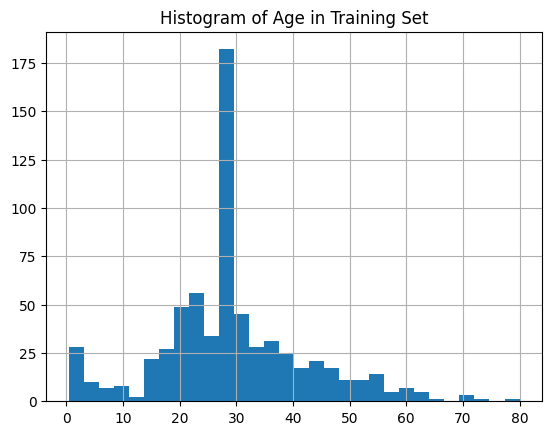

In [16]:
ax = X_train['Age'].hist(bins=30)
ax = plt.title("Histogram of Age in Training Set")

Mean age: 29.14047904191617
Standard Deviation of age: 13.02181499397036


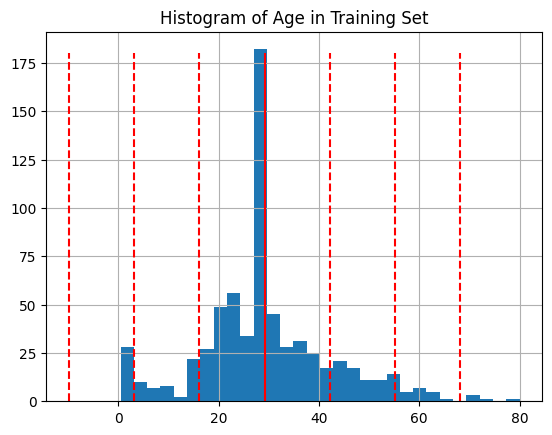

In [17]:
ax = X_train['Age'].hist(bins=30)
ax = plt.title("Histogram of Age in Training Set")

mean_age = np.mean(X_train['Age'])
print(f"Mean age: {mean_age}")
stdev_age = statistics.stdev(X_train['Age'])
print(f"Standard Deviation of age: {stdev_age}")

plt.vlines(x=mean_age, colors="red", ymin=0, ymax=180)
plt.vlines(x=mean_age+stdev_age, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_age+stdev_age*2, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_age+stdev_age*3, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_age-stdev_age, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_age-stdev_age*2, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_age-stdev_age*3, colors="red", ymin=0, ymax=180, linestyles="--")

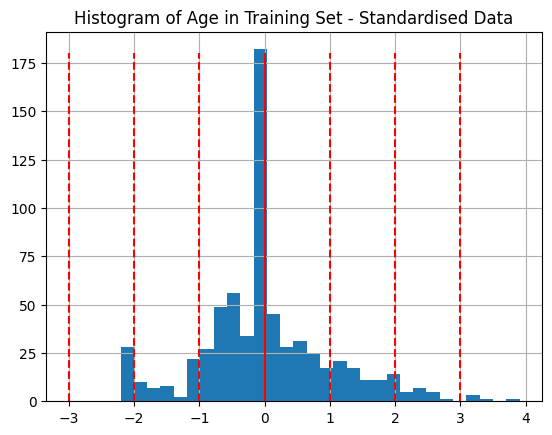

In [18]:
ax = plt.hist(X_train_std[:, 1],bins=30)
mean_age = np.mean(X_train_std[:, 1])
stdev_age = statistics.stdev(X_train_std[:, 1])
plt.vlines(x=mean_age, colors="red", ymin=0, ymax=180)
plt.vlines(x=mean_age+stdev_age, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_age+stdev_age*2, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_age+stdev_age*3, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_age-stdev_age, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_age-stdev_age*2, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_age-stdev_age*3, colors="red", ymin=0, ymax=180, linestyles="--")
plt.grid()
ax = plt.title("Histogram of Age in Training Set - Standardised Data")


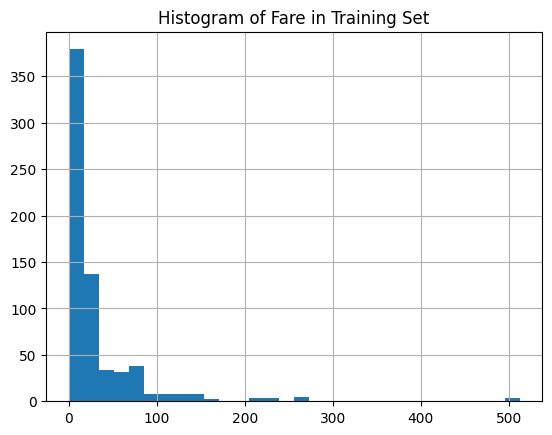

In [19]:
X_train['Fare'].hist(bins=30)
ax = plt.title("Histogram of Fare in Training Set")

Mean fare: 32.17939670658683
Standard Deviation of fare: 51.60401208218659


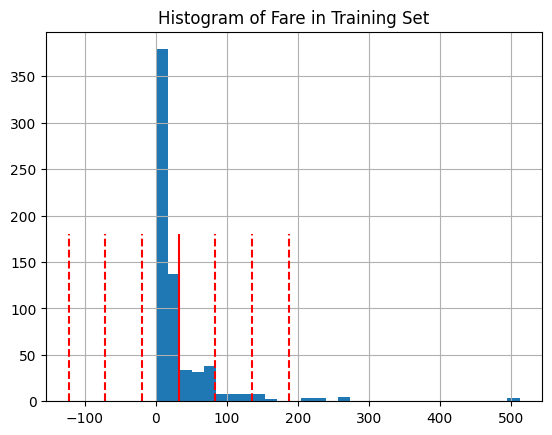

In [20]:
X_train['Fare'].hist(bins=30)
ax = plt.title("Histogram of Fare in Training Set")
mean_fare = np.mean(X_train['Fare'])
print(f"Mean fare: {mean_fare}")
stdev_fare = statistics.stdev(X_train['Fare'])
print(f"Standard Deviation of fare: {stdev_fare}")
plt.vlines(x=mean_fare, colors="red", ymin=0, ymax=180)
plt.vlines(x=mean_fare+stdev_fare, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_fare+stdev_fare*2, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_fare+stdev_fare*3, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_fare-stdev_fare, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_fare-stdev_fare*2, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_fare-stdev_fare*3, colors="red", ymin=0, ymax=180, linestyles="--")

Mean fare: 1.0007493444288698
Standard Deviation of fare: 1.0007493444288698


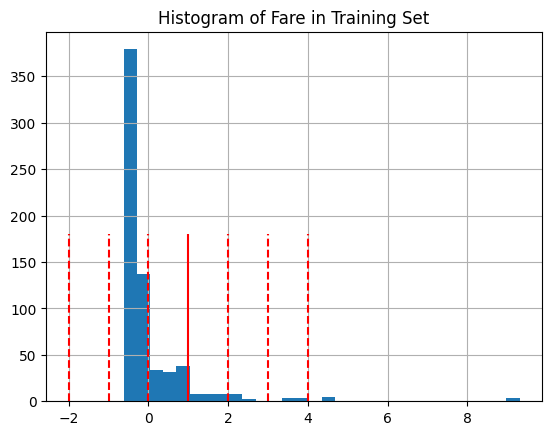

In [21]:
ax = plt.hist(X_train_std[:,4], bins=30)
ax = plt.title("Histogram of Fare in Training Set")
mean_fare = statistics.stdev(X_train_std[:,4])
print(f"Mean fare: {mean_fare}")
stdev_fare = statistics.stdev(X_train_std[:,4])
print(f"Standard Deviation of fare: {stdev_age}")
plt.vlines(x=mean_fare, colors="red", ymin=0, ymax=180)
plt.vlines(x=mean_fare+stdev_fare, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_fare+stdev_fare*2, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_fare+stdev_fare*3, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_fare-stdev_fare, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_fare-stdev_fare*2, colors="red", ymin=0, ymax=180, linestyles="--")
plt.vlines(x=mean_fare-stdev_fare*3, colors="red", ymin=0, ymax=180, linestyles="--")
plt.grid()

## Fit logistic regression model

Now we will fit a logistic regression model, using sklearn's `LogisticRegression` method. Our machine learning model fitting (training) is only two lines of code!
By using the name `model` for our logistic regression model we will make our model more interchangeable later on if we wanted to try a different kind of model, for example.

In [22]:
model = LogisticRegression()
model.fit(X_train_std,y_train)

LogisticRegression()

## Predict values

Now we can use the trained model to predict survival. We will test the accuracy of both the training and test data sets.

In [23]:
# Predict training and test set labels
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)

## Calculate accuracy

In this example we will measure accuracy simply as the proportion of passengers where we make the correct prediction. In later examples we will look at other measures of accuracy which explore false positives and false negatives in more detail.

In [24]:
# The shorthand below says to check each predicted y value against the actual
# y value in the training data.  This gives a list of True and False values
# for each prediction, where True indicates the predicted value matches the
# actual value.  Then we take the mean of these Boolean values, which gives
# us a proportion (where if all values were True, the proportion would be 1.0)
# If you want to see why that works, just uncomment the following line of code
# to see what y_pred_train == y_train is doing.
# print (y_pred_train == y_train)
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train}')
print (f'Accuracy of predicting test data = {accuracy_test}')

Accuracy of predicting training data = 0.8083832335329342
Accuracy of predicting test data = 0.8116591928251121


Not bad - about 80% accuracy. You will probably see that accuracy of predicting the training set is usually higher than the test set. Because we are only testing one random sample, you may occasionally see otherwise. In later examples we will look at the best way to repeat multiple tests, and look at what to do if the accuracy of the training set is significantly higher than the test set (a problem called 'overfitting').

## Examining the model coefficients (weights)

Not all features are equally important. And some may be of little or no use at all, unnecessarily increasing the complexity of the model. In later examples we will look at selecting features which add value to the model (or removing features that don’t).

Here we will look at the importance of features – how they affect our estimation of survival. These are known as the model *coefficients* (if you come from a traditional statistics background), or model *weights* (if you come from a machine learning background). 

Because we have standardised our input data the magnitude of the weights may be compared as an indicator of their influence in the model. Weights with higher negative numbers mean that that feature correlates with reduced chance of survival. Weights with higher positive numbers mean that that feature correlates with increased chance of survival. Those weights with values closer to zero (either positive or negative) have less influence in the model.

We access the model weights my examining the model `coef_` attribute. The model may predict more than one outcome label, in which case we have weights for each label. Because we are predicting a single label here (survive or not), the weights are found in the first element (`[0]`) of the `coef_` attribute.

In [26]:
co_eff = model.coef_[0]
co_eff

array([-0.59933416, -0.44334034, -0.32650096, -0.12092065,  0.20049511,
       -0.20985474,  0.09770207,  0.07977789,  0.12022711, -0.38167408,
       -1.28561786,  0.10666948,  0.05522223, -0.13920157,  0.09770207,
       -0.0581842 , -0.04534243, -0.24337741,  0.0598707 ,  0.17427913,
        0.13557114, -0.13129024, -0.15952828,  0.07977789])

So we have an array of model weights.

Not very readable for us mere humans is it?!

We will transfer the weights array to a Pandas DataFrame. The array order is in the same order of the list of features of X, so we will put that those into the DataFrame as well. And we will sort by influence in the model. Because both large negative and positive values are more influential in the model we will take the *absolute* value of the weight (ie remove any negative sign), and then sort by that absolute value. That will give us a more readable table of most influential features in the model.

In [27]:
co_eff_df = pd.DataFrame() # create empty DataFrame
co_eff_df['feature'] = list(X) # Get feature names from X
co_eff_df['co_eff'] = co_eff
co_eff_df['abs_co_eff'] = np.abs(co_eff)
co_eff_df.sort_values(by='abs_co_eff', ascending=False, inplace=True)

Let's look at the DataFrame.  What do you conclude?

In [394]:
co_eff_df

,feature,co_eff,abs_co_eff
10,male,-1.285618,1.285618
0,Pclass,-0.599334,0.599334
1,Age,-0.443340,0.443340
9,CabinNumberImputed,-0.381674,0.381674
2,SibSp,-0.326501,0.326501
17,CabinLetter_C,-0.243377,0.243377
5,AgeImputed,-0.209855,0.209855
4,Fare,0.200495,0.200495
19,CabinLetter_E,0.174279,0.174279
22,CabinLetter_T,-0.159528,0.159528


Now - the actual order of features, and the weights for each, will be different each time you fit the model, as it's random and we haven't put in place any controls.  So don't worry if yours differs a bit.  But, you'll likely find that amongst the top weighted features are :

* male (being male reduces probability of survival)
* Pclass (lower class passengers, who have a higher class number, reduces probability of survival)
* age (being older reduces probability of survival)
* CabinNumberImputed (cabin number is missing, which may mean they didn't have a cabin - likely lower class)

Let's add the odds to the dataframe.

In [28]:
co_eff_df['odds'] = np.exp(co_eff_df['co_eff'])
co_eff_df

,feature,co_eff,abs_co_eff,odds
10,male,-1.285618,1.285618,0.276480
0,Pclass,-0.599334,0.599334,0.549177
1,Age,-0.443340,0.443340,0.641889
9,CabinNumberImputed,-0.381674,0.381674,0.682718
2,SibSp,-0.326501,0.326501,0.721444
17,CabinLetter_C,-0.243377,0.243377,0.783976
5,AgeImputed,-0.209855,0.209855,0.810702
4,Fare,0.200495,0.200495,1.222008
19,CabinLetter_E,0.174279,0.174279,1.190388
22,CabinLetter_T,-0.159528,0.159528,0.852546


Finally, let's convert this to a change in probability.

In [29]:
intercept = model.intercept_[0]

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

baseline_prob = sigmoid(intercept)

def prob_change(coef, intercept):
    baseline = sigmoid(intercept)
    new_prob = sigmoid(intercept + coef)
    return new_prob - baseline

co_eff_df['probability_changes'] = [prob_change(coef, intercept) for coef in co_eff_df['co_eff']]

In [30]:
co_eff_df

,feature,co_eff,abs_co_eff,odds,probability_changes
10,male,-1.285618,1.285618,0.276480,-0.217047
0,Pclass,-0.599334,0.599334,0.549177,-0.120259
1,Age,-0.443340,0.443340,0.641889,-0.092060
9,CabinNumberImputed,-0.381674,0.381674,0.682718,-0.080281
2,SibSp,-0.326501,0.326501,0.721444,-0.069446
17,CabinLetter_C,-0.243377,0.243377,0.783976,-0.052607
5,AgeImputed,-0.209855,0.209855,0.810702,-0.045646
4,Fare,0.200495,0.200495,1.222008,0.046509
19,CabinLetter_E,0.174279,0.174279,1.190388,0.040291
22,CabinLetter_T,-0.159528,0.159528,0.852546,-0.035018


## Show predicted probabilities

The predicted probabilities are for the two alternative classes 0 (does not survive) or 1 (survive).

Ordinarily we do not see these probabilities - the `predict` method used above applies a cut-off of 0.5 to classify passengers into survived or not, but we can see the individual probabilities for each passenger if desired.

In a later example we will see how we can use such probabilities to adjust the sensitivity of our model to detecting survivors or non-survivors.

Each passenger has two values. These are the probability of not surviving (first value) or surviving (second value). Because we only have two possible classes we only need to look at one. Multiple values are important when there are more than one class being predicted.

In [32]:
# Show first ten predicted classes
classes = model.predict(X_test_std)
classes[0:10]

array([0., 0., 0., 1., 1., 1., 1., 0., 1., 1.])

In [33]:
# Show first ten predicted probabilities
# (note how the values relate to the classes predicted above)
probabilities = model.predict_proba(X_test_std)
probabilities[0:10]

array([[0.93647344, 0.06352656],
       [0.83235068, 0.16764932],
       [0.87320715, 0.12679285],
       [0.1350535 , 0.8649465 ],
       [0.25288959, 0.74711041],
       [0.09785614, 0.90214386],
       [0.3968734 , 0.6031266 ],
       [0.9284447 , 0.0715553 ],
       [0.20571976, 0.79428024],
       [0.05239181, 0.94760819]])

## Prediction Uncertainty

We can use bootstrapping - resampling with replacement - to retrain the model on multiple slightly different training sets and see the impact on the predictions.

This gives us some idea of how 'certain' predictions are and how robust the model is to changes in the mix of training data.

In [34]:
splits = 30
train_set = []

for i in range(splits):
    train_set.append(X_train.join(y_train).sample(frac=1, replace=True))

In [35]:
# Set up lists for models and probability predictions
models = []
results  = []
accuracies = []

for i in range(splits):

    # Get X and y
    X_train = train_set[i].drop('Survived', axis=1)
    y_train = train_set[i]['Survived']

    X_train_std, X_test_std = standardise_data(X_train, X_test)

    # Define and train model; use different random seed for each model
    model = LogisticRegression(random_state=42+i)
    model.fit(X_train_std, y_train)
    models.append(model)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_std)[:,1]
    y_pred = y_probs > 0.5
    results.append([y_probs])

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

results = np.array(results)
results = results.T.reshape(-1, splits)

#### Accuracy Across Models

In [36]:
print (f'Mean accuracy: {np.mean(accuracies):0.3f}')

Mean accuracy: 0.803


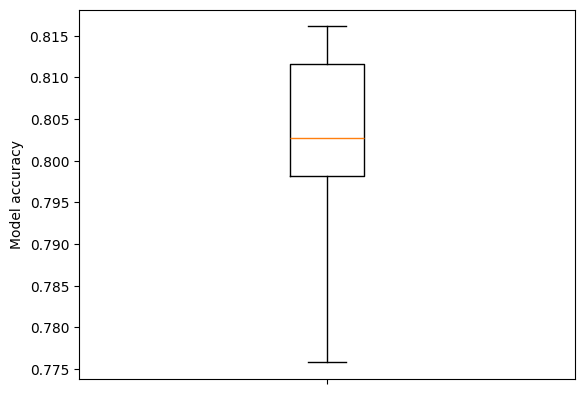

In [37]:
fig = plt.figure()
ax = fig.add_subplot()
ax.boxplot(accuracies, whis=999)
ax.set_ylabel('Model accuracy')
ax.axes.xaxis.set_ticklabels([]) # Remove xtick labels
plt.show()

### Classification consensus

In [38]:
classification = results >= 0.5
consensus = classification.sum(axis=1) >= splits/2
consensus_accuracy = np.mean(consensus == y_test)
print (f'Consensus accuracy: {consensus_accuracy:0.3f}')

Consensus accuracy: 0.803


### Variation in predictions

#### Standard Deviation

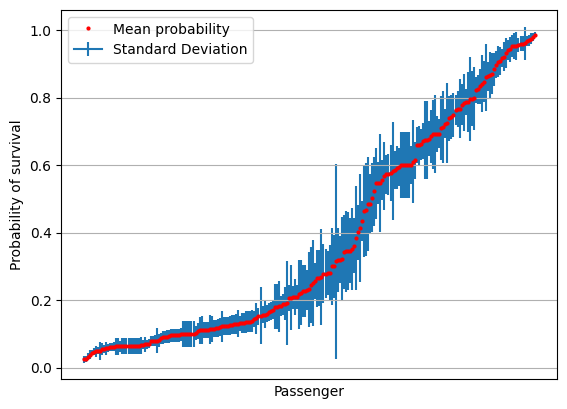

In [39]:
results = results[np.mean(results,axis=1).argsort()]
mean = np.mean(results,axis=1)
stdev = np.std(results,axis=1)

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(range(len(mean)), mean, yerr=stdev, label='Standard Deviation', zorder=1)
ax.plot(mean, 'o', c='r', markersize=2, label = 'Mean probability', zorder=2)
ax.axes.xaxis.set_ticklabels([])
ax.set_xlabel('Passenger')
ax.set_ylabel('Probability of survival')
ax.set_xticks([])
ax.grid()
ax.legend()
plt.show()


### Standard Error

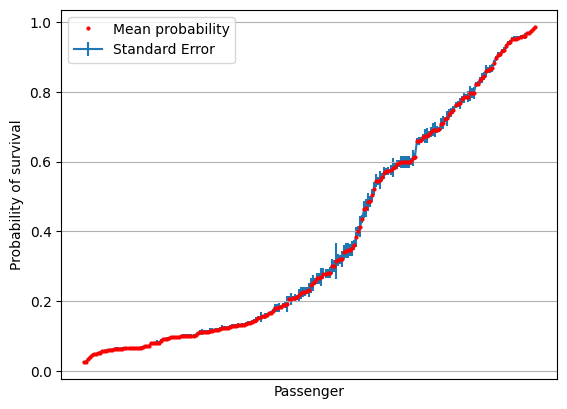

In [40]:
# Sort by mean survival
results = results[np.mean(results,axis=1).argsort()]

mean = np.mean(results,axis=1)
stdev = np.std(results,axis=1)
se = stdev / np.sqrt(splits)

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(range(len(mean)), mean, yerr=se, label='Standard Error', zorder=1)
ax.plot(mean, 'o', c='r', markersize=2, label = 'Mean probability', zorder=2)
ax.axes.xaxis.set_ticklabels([])
ax.set_xlabel('Passenger')
ax.set_ylabel('Probability of survival')
ax.set_xticks([])
ax.grid()
ax.legend()
plt.show()

## Repeat with XGBoost

In [41]:
# Set up lists for models and probability predictions
models = []
results  = []
accuracies = []

for i in range(splits):

    # Get X and y
    X_train = train_set[i].drop('Survived', axis=1)
    y_train = train_set[i]['Survived']

    # Define and train model; use different random seed for each model
    model = XGBClassifier(random_state=42+i)
    model.fit(X_train, y_train)
    models.append(model)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    y_pred = y_probs > 0.5
    results.append([y_probs])

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

results = np.array(results)
results = results.T.reshape(-1, splits)

In [408]:
print (f'Mean accuracy: {np.mean(accuracies):0.3f}')

Mean accuracy: 0.790


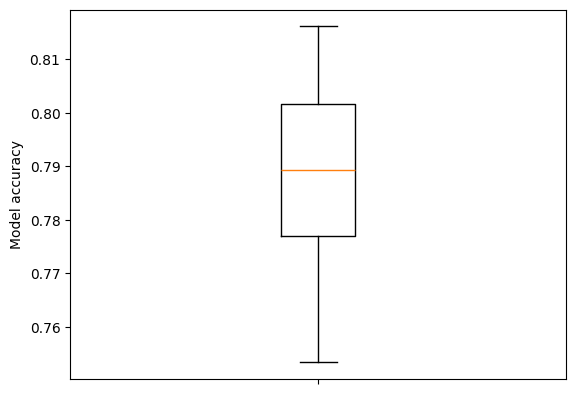

In [409]:
fig = plt.figure()
ax = fig.add_subplot()
ax.boxplot(accuracies, whis=999)
ax.set_ylabel('Model accuracy')
ax.axes.xaxis.set_ticklabels([]) # Remove xtick labels
plt.show()

In [42]:
classification = results >= 0.5
consensus = classification.sum(axis=1) >= splits/2
consensus_accuracy = np.mean(consensus == y_test)
print (f'Consensus accuracy: {consensus_accuracy:0.3f}')

Consensus accuracy: 0.807


#### Variation in Predictions: Standard Deviation

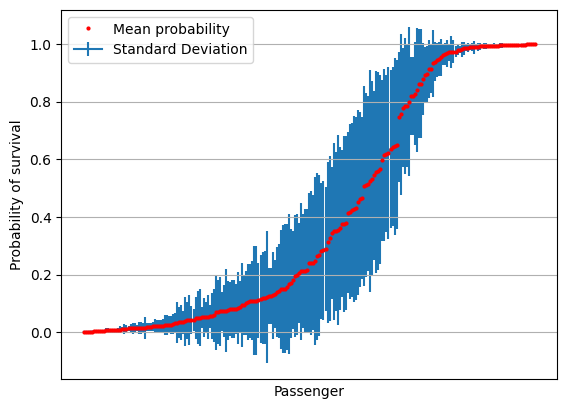

In [43]:
results = results[np.mean(results,axis=1).argsort()]
mean = np.mean(results,axis=1)
stdev = np.std(results,axis=1)

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(range(len(mean)), mean, yerr=stdev, label='Standard Deviation', zorder=1)
ax.plot(mean, 'o', c='r', markersize=2, label = 'Mean probability', zorder=2)
ax.axes.xaxis.set_ticklabels([])
ax.set_xlabel('Passenger')
ax.set_ylabel('Probability of survival')
ax.set_xticks([])
ax.grid()
ax.legend()
plt.show()


### Standard Error

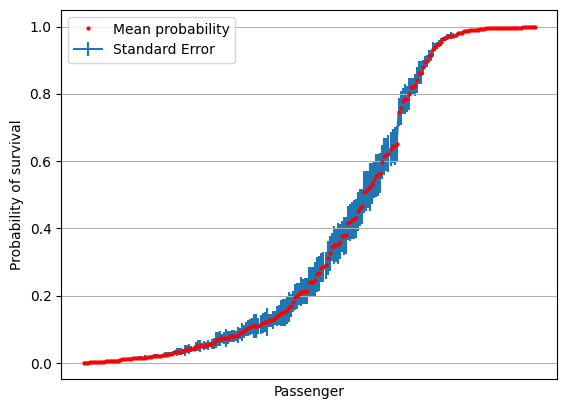

In [44]:
mean = np.mean(results,axis=1)
stdev = np.std(results,axis=1)
se = stdev / np.sqrt(splits)

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(range(len(mean)), mean, yerr=se, label='Standard Error', zorder=1)
ax.plot(mean, 'o', c='r', markersize=2, label = 'Mean probability', zorder=2)
ax.axes.xaxis.set_ticklabels([])
ax.set_xlabel('Passenger')
ax.set_ylabel('Probability of survival')
ax.set_xticks([])
ax.grid()
ax.legend()
plt.show()

# ICE and PDP

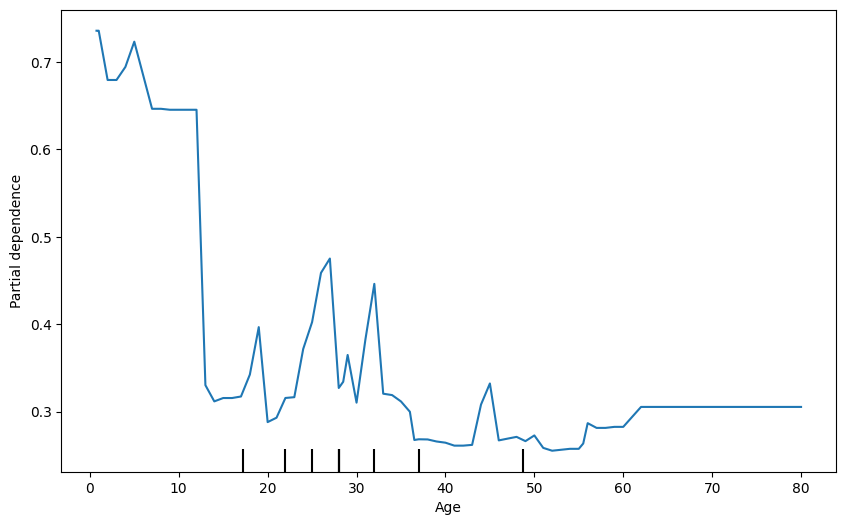

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    features=['Age'],  # List of features to plot
    target=0,
    kind='average',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

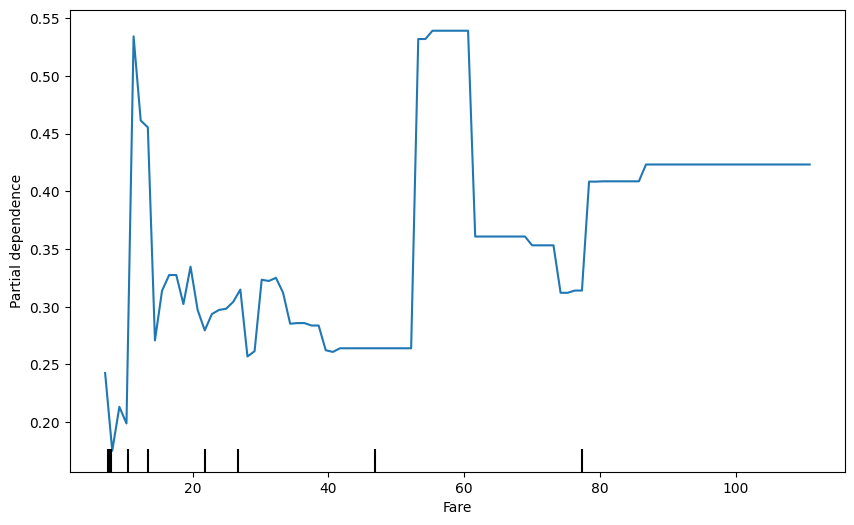

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    features=['Fare'],  # List of features to plot
    target=0,
    kind='average',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

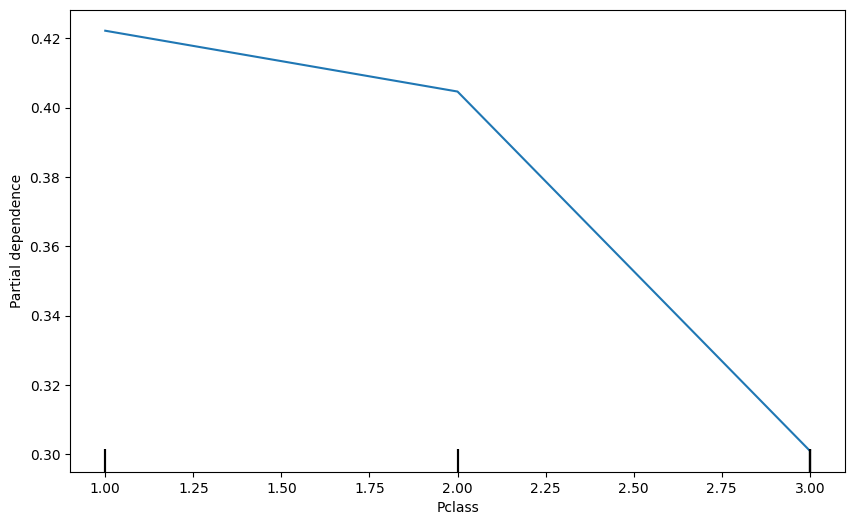

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    features=['Pclass'],  # List of features to plot
    target=0,
    kind='average',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

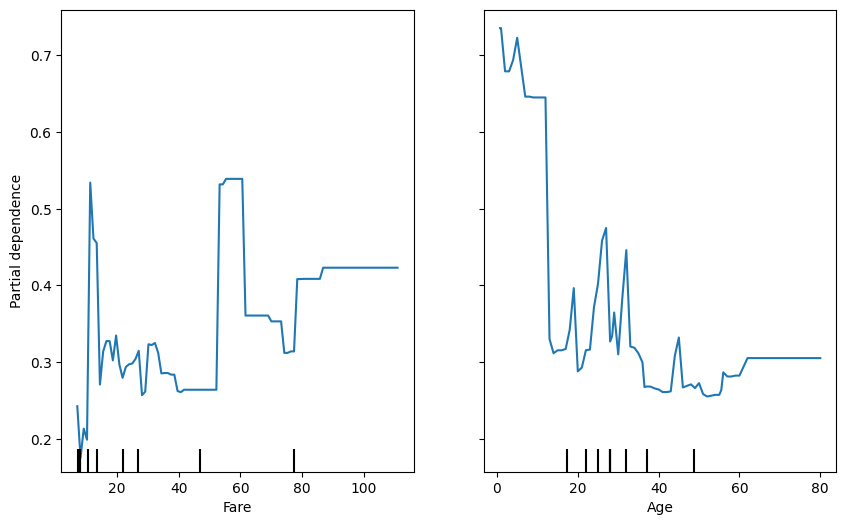

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

display1 = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    features=['Fare', 'Age'],  # List of features to plot
    target=0,
    kind='average',  # Type of PDP
    random_state=42,
    ax=ax
)

#### Centred plot

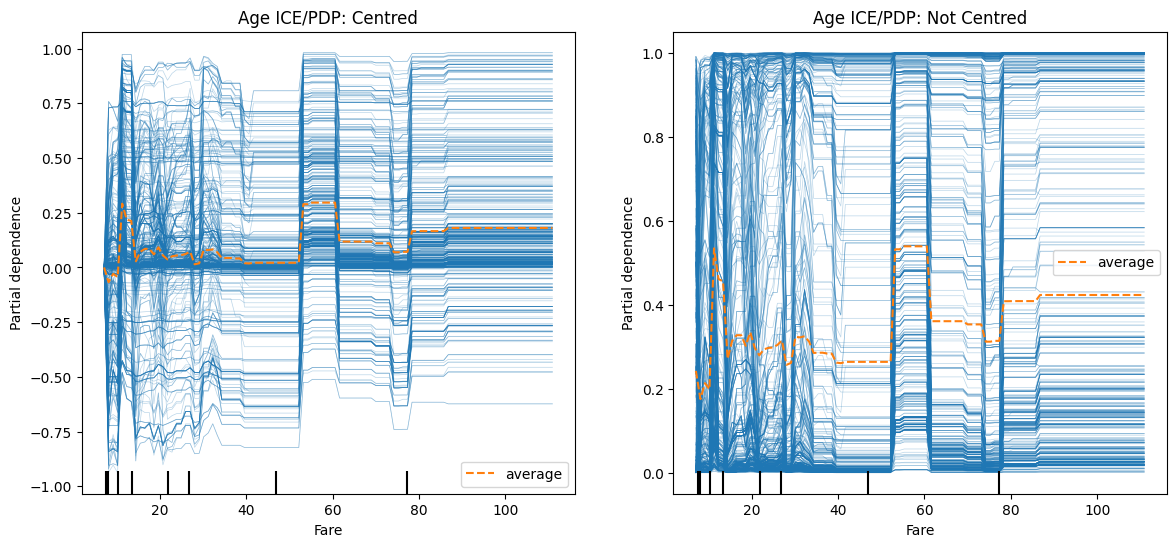

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
display_centred = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    features=['Fare'],  # List of features to plot
    target=0,
    kind='both',  # Type of PDP
    ax=ax1,
    centered=True,
    random_state=42
)
ax1.set_title("Age ICE/PDP: Centred")
display_standard = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    features=['Fare'],  # List of features to plot
    target=0,
    kind='both',  # Type of PDP
    ax=ax2,
    centered=False,
    random_state=42
)
ax2.set_title("Age ICE/PDP: Not Centred")
plt.show()